In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pymysql
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
con = pymysql.connect(host='localhost', user='root',password='Karelia',database='Wolt')

In [156]:
def cohort_month(product_line):
    #return a dataframe with month numbered in integers
    #for matching product line (argument) in database
    #unique count of users in that month, grouped into 
    #how many months since they first purchased
    con.connect()
    select_main = con.cursor()
    statement = """
    SELECT 
    DATE_FORMAT(Purchases.first_purchase_date, "%m")as purchase_date,
    COUNT(DISTINCT(Purchases.user_id) ) as 'unique_customers',TIMESTAMPDIFF(MONTH,First_Purchases.first_purchase_date,Purchases.first_purchase_date) as since_first
    from Purchases
    CROSS JOIN First_Purchases
    WHERE Purchases.user_id = First_Purchases.user_id and Purchases.product_line = '{}'
    group by purchase_date,since_first;
    """.format(product_line)
    select_main.execute(statement)
    rows = select_main.fetchall()
    columns =  [i[0] for i in select_main.description]
    con.commit()
    con.close()
    framer = pd.DataFrame(rows,columns=columns)
    framer.purchase_date = [datetime.datetime(2020, int(i), 1).strftime("%B") for i in framer.purchase_date]
    framer.name = product_line + ' Cohort'
    return framer

In [157]:
def plottable(cohort):
    #returns a dataframe with the SQL results in a matrix, which is suitable for plotting
    cohort = pd.pivot_table(cohort,index='purchase_date',columns='since_first',values='unique_customers',sort=False).fillna(0)
    return cohort
    

In [158]:
def cohort_subplots(cohort_frame):
    #returns n number of subplots depending on lenght ofcolumns
    #renders in each suplot, month on X axis, and number of unique users in Y axis
    #the data for each sublot is the number of months since first purchase, indexed by month
    #good for just displaying raw data for further exploration
    sup_title = cohort_frame.name
    format_thousands =  '{:,}'
    cohort_frame = plottable(cohort_frame)
    fig, ax = plt.subplots(nrows=len(cohort_frame.columns), ncols=1)
    fig.set_figheight(30)
    fig.set_figwidth(20)
    fig.suptitle(sup_title,x=0.52)
    for num,i in enumerate(cohort_frame.columns):
        selected = cohort_frame[i]
        total = format_thousands.format(int(selected.sum()))
        
        if num != 0:
            title = '{} month(s) since first purchase\ntotal unique users: {}'.format(num,total)
        else:
            title = 'same month of purchase\ntotal unique users: {}'.format(total)
        
        average = {'mean': format_thousands.format(round(selected[selected> 0].mean(),2)),'range':str(len(selected[selected> 0])) }
        if int(average['range']) > 1: title = title +'\naverage (unique) monthly users in {} month range: {}\n'.format(average['range'],average['mean'])
        
        cohort_frame[i].plot.bar(ax=ax[num],title=title)
        ax[num].set_xticklabels(selected.index, rotation=0)
        ax[num].set_xlabel("cohort month")
        ax[num].set_ylabel("unique users in month")
        ax[num].set_ylim(ymax=cohort_frame.to_numpy().max()*1.2)
        
        for index,value in zip(range(len(selected.index)),selected.tolist()):
            if value == 0:
                pass
            else:
                xys=(index,value+cohort_frame.to_numpy().max()/8)
                ax[num].annotate( format_thousands.format(int(value)), xy=xys, ha='center', va='center')
        
    fig.tight_layout()
    fig.tight_layout(pad=3.0)

In [159]:
def cohort_heatmap(cohort_frame):
    #converts data to matrix of month, n months since first purchase
    #with percentage share of total users in that month  spanning cohort months
    #it's easy to see how the number drops if you follow the lower row
    #one block to the right, relative to preceeding row
    title = cohort_frame.name
    cohort_frame = plottable(cohort_frame)
    cohort_frame = cohort_frame.T.iloc[:, ].apply(lambda x: x / x.sum() * 100).T
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cohort_frame,cmap='Reds')
   
    for i in range(len(cohort_frame.index)):
        for j in range(len(cohort_frame.columns)):
            if cohort_frame[j][i] == 0:
                pass
            else:
                value = str(round(cohort_frame[j][i],2))+'%'
                text = ax.text(j, i, value,ha="center", va="center", color="black")

    ax.set_yticks(np.arange(0,len(cohort_frame.index)))
    ax.set_yticklabels(cohort_frame.index)
    ax.set_ylabel("Cohort Month")
    ax.set_xlabel("month(s) since first purchase")
    ax.set_title('{}: Percentage share of users in cohort month, since first purchase in months '.format(title))
    ax.grid(False)

In [160]:
cohort_retail_month = cohort_month('Retail Store')
cohort_restaurant_month = cohort_month('Restaurant')

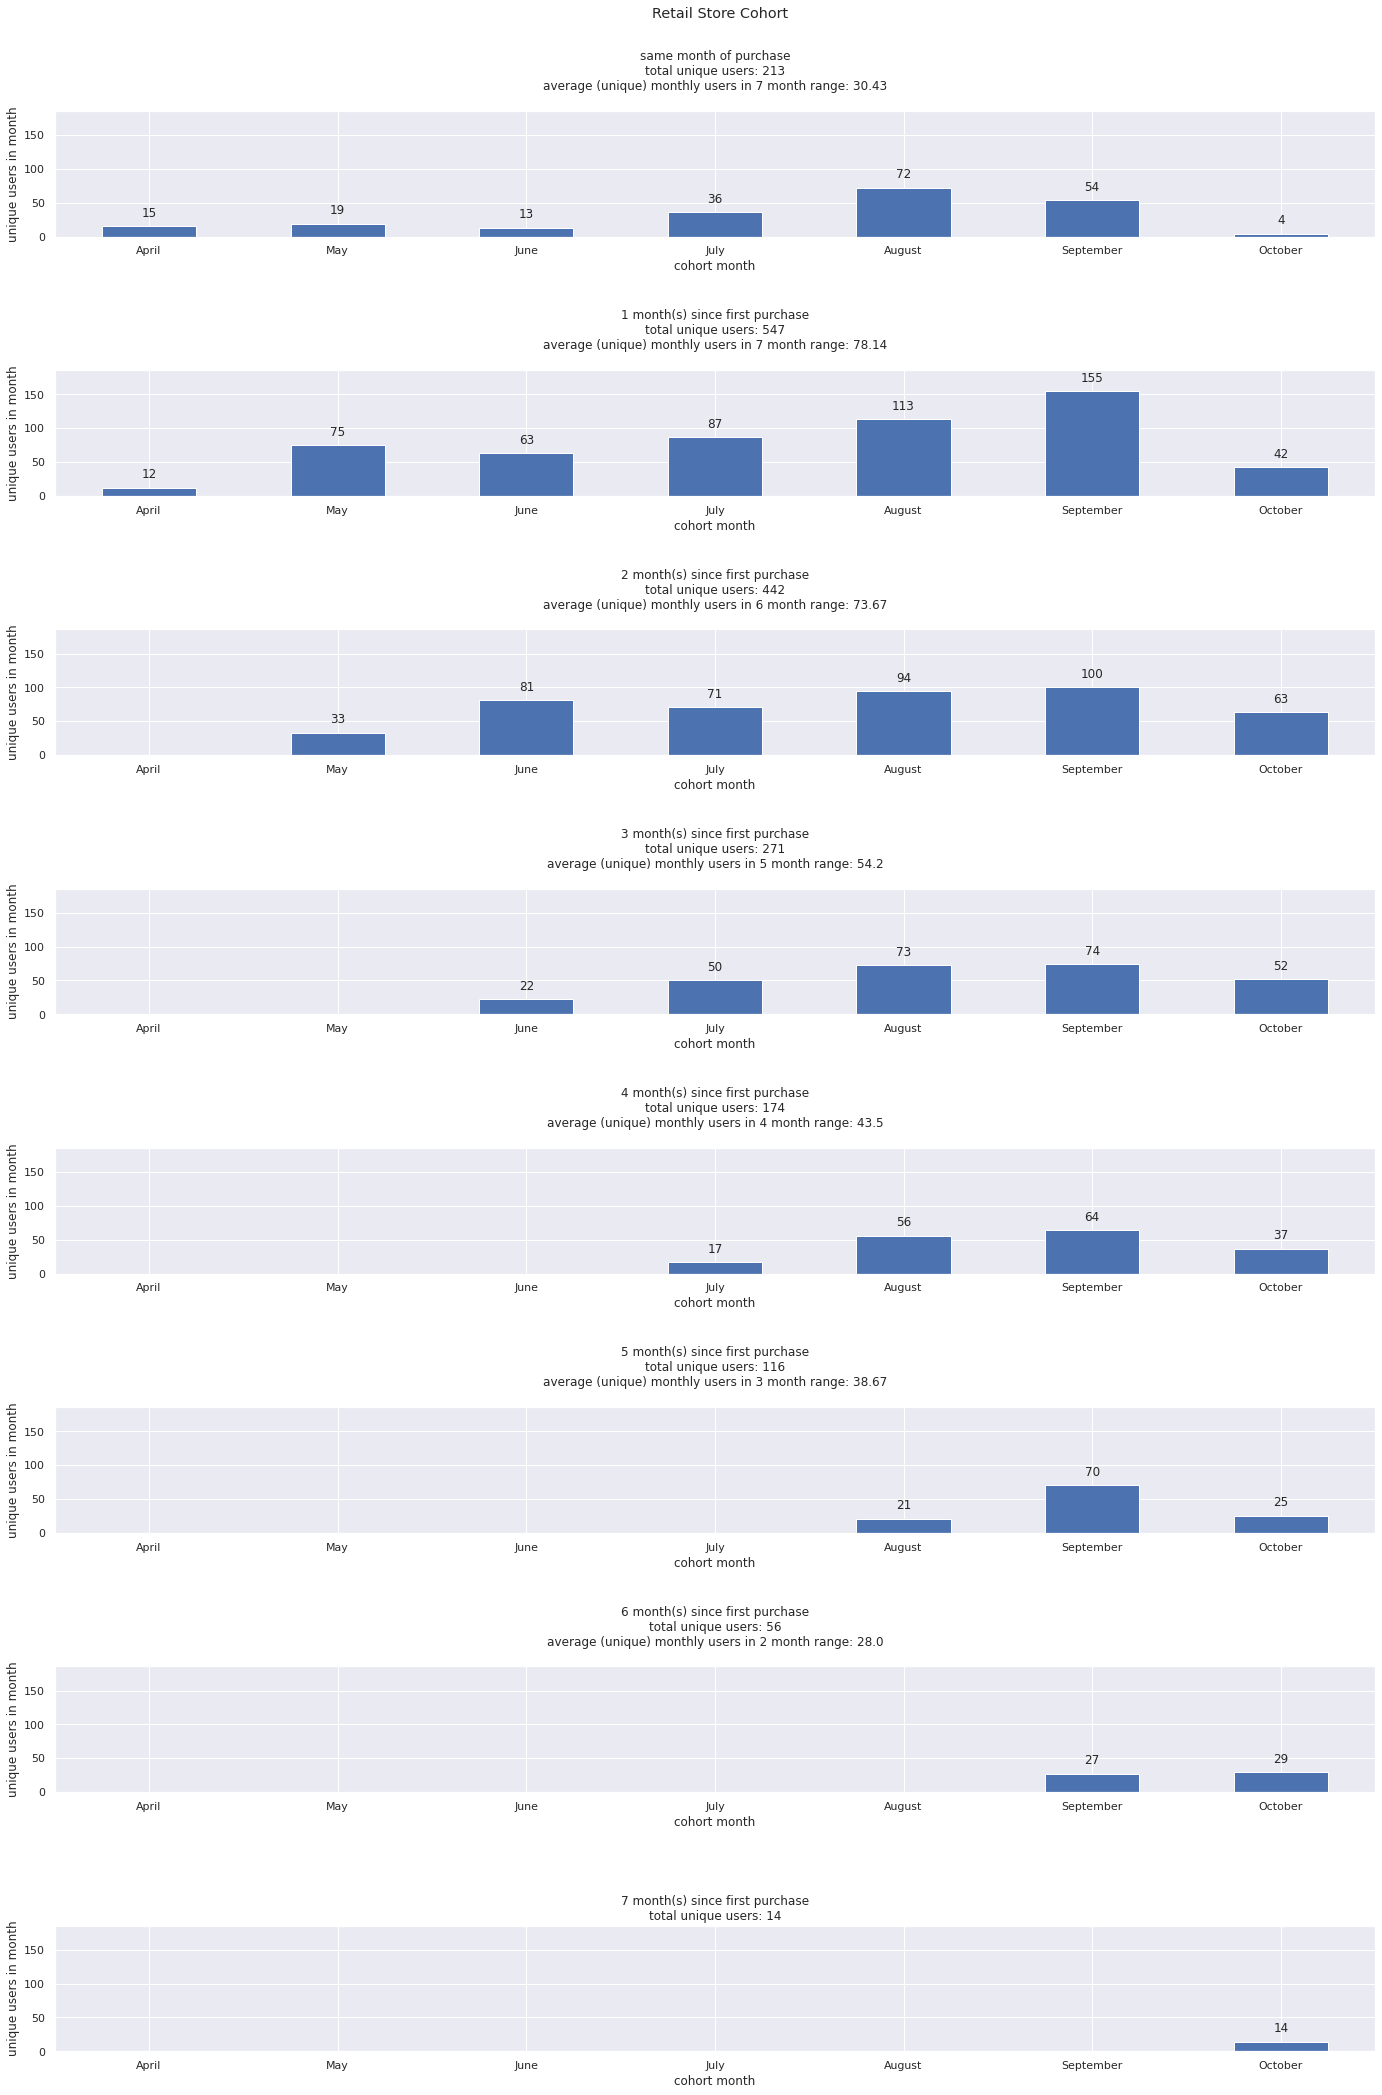

In [161]:
cohort_subplots(cohort_retail_month)

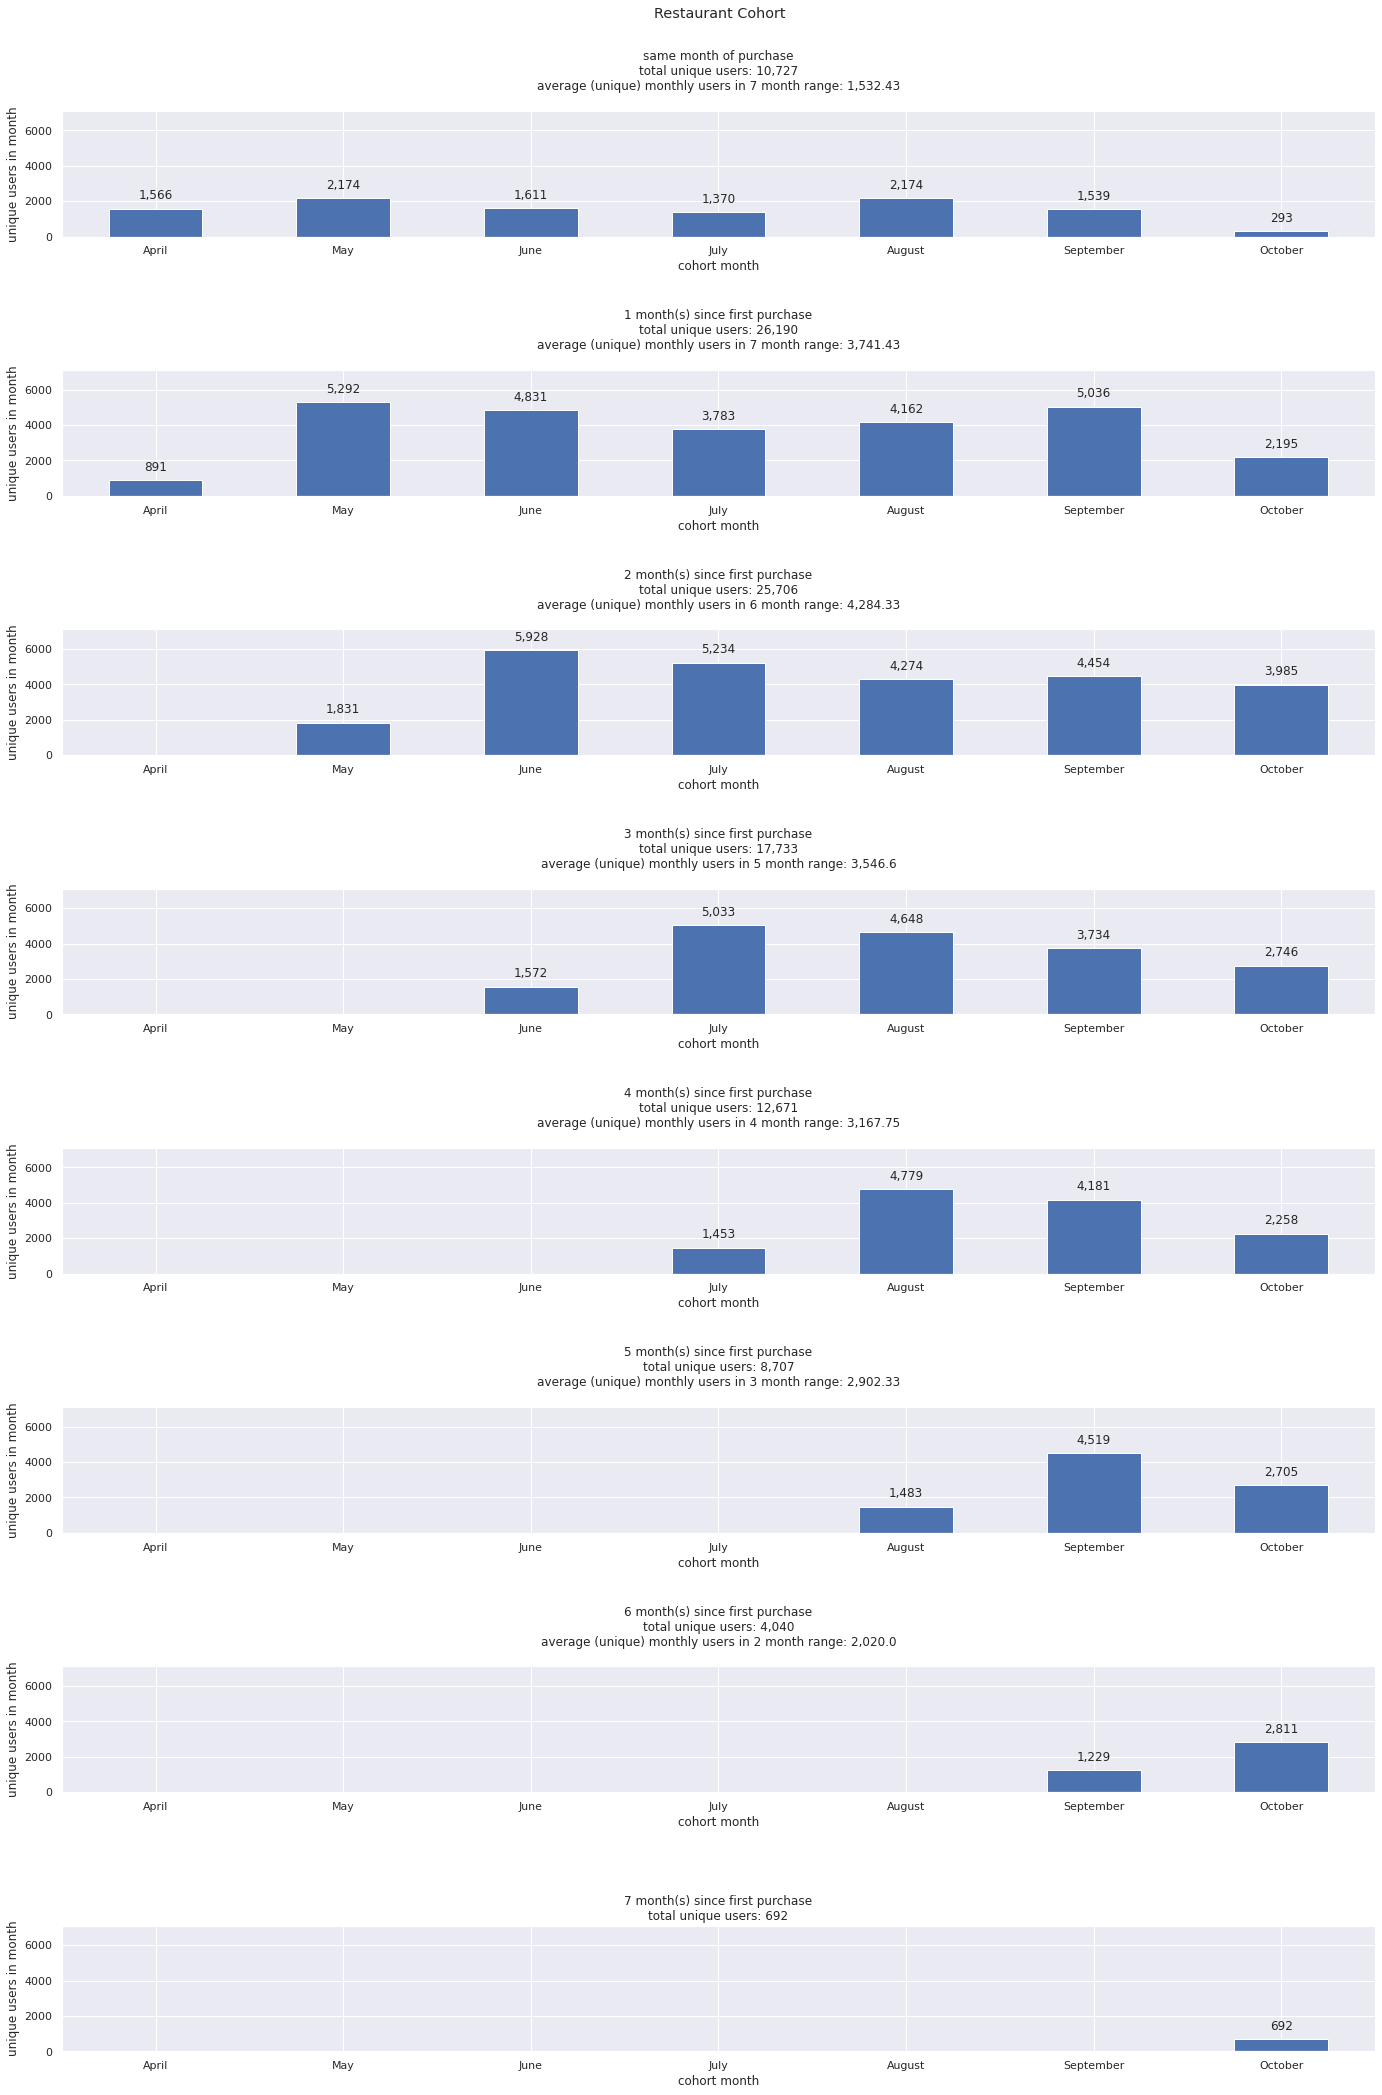

In [162]:
cohort_subplots(cohort_restaurant_month)

In [163]:
def compare_cohorts(cohorts):
    #returns plots on arbitrary number of cohorts with
    #mean retention (unique users per month) across all months in matrix
    #with a horizontal line representing if value falls above or below overall mean
    fig, ax = plt.subplots(nrows=len(cohorts), ncols=1)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    format_thousands =  '{:,}'
    fig.suptitle('Mean monthly activity since first purchase',x=0.52)
    for num,cohort in enumerate(cohorts):
        title = cohort.name
        selected = plottable(cohort).mean().round(2)
        ax[num].axhline(y=selected.to_numpy().mean(), color='r', linestyle='-',zorder=0,label="horizontal")
        selected.plot.bar(ax=ax[num])
        labels = ["overall mean retention", "mean retention"]
        handles, _ = ax[num].get_legend_handles_labels()
        ax[num].legend(handles = handles, labels = labels)
        ax[num].set_title(title)
        ax[num].set_ylabel("Mean activity")
        ax[num].set_xlabel("month(s) since first purchase")
        for index,value in zip(range(len(selected.index)),selected.tolist()):
            xys=(index,value+selected.to_numpy().max()/25)
            ax[num].annotate(format_thousands.format(int(value)), xy=xys, ha='center', va='center')
    
    fig.tight_layout()
    fig.tight_layout(pad=2.0)
    

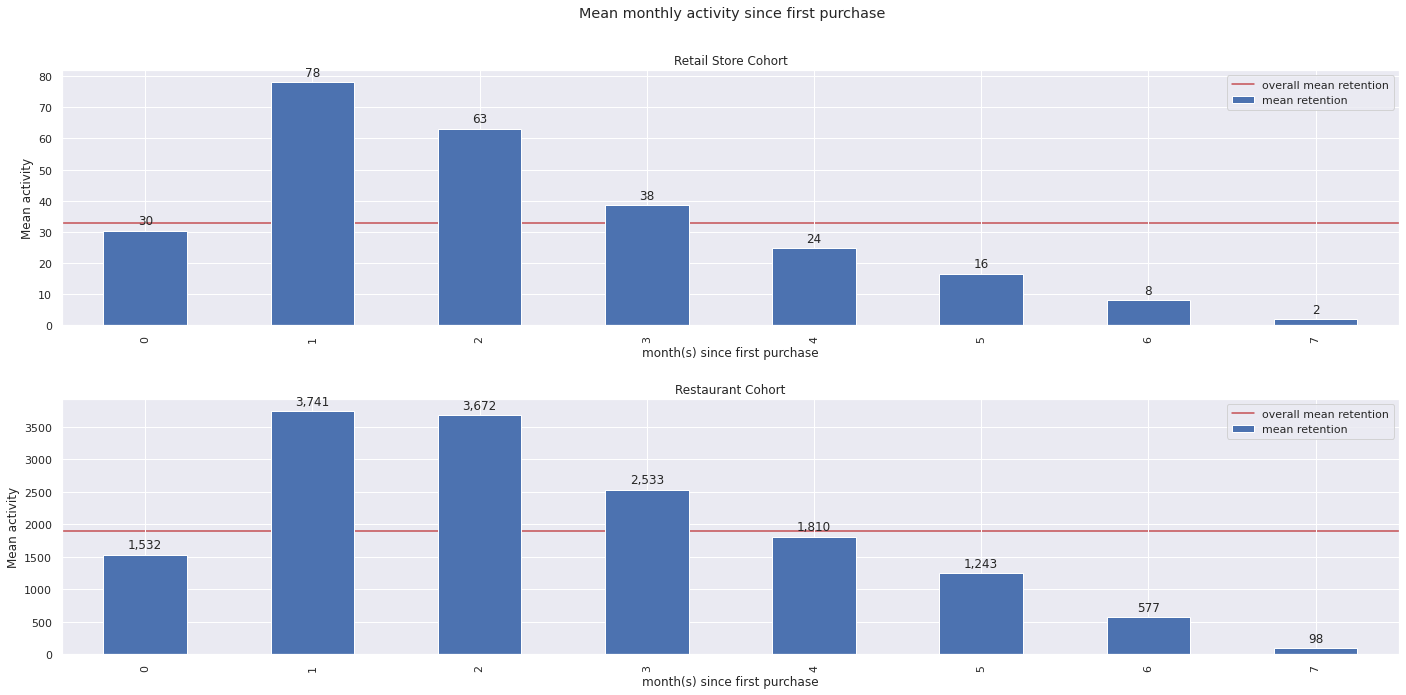

In [164]:
compare_cohorts([cohort_retail_month,cohort_restaurant_month])

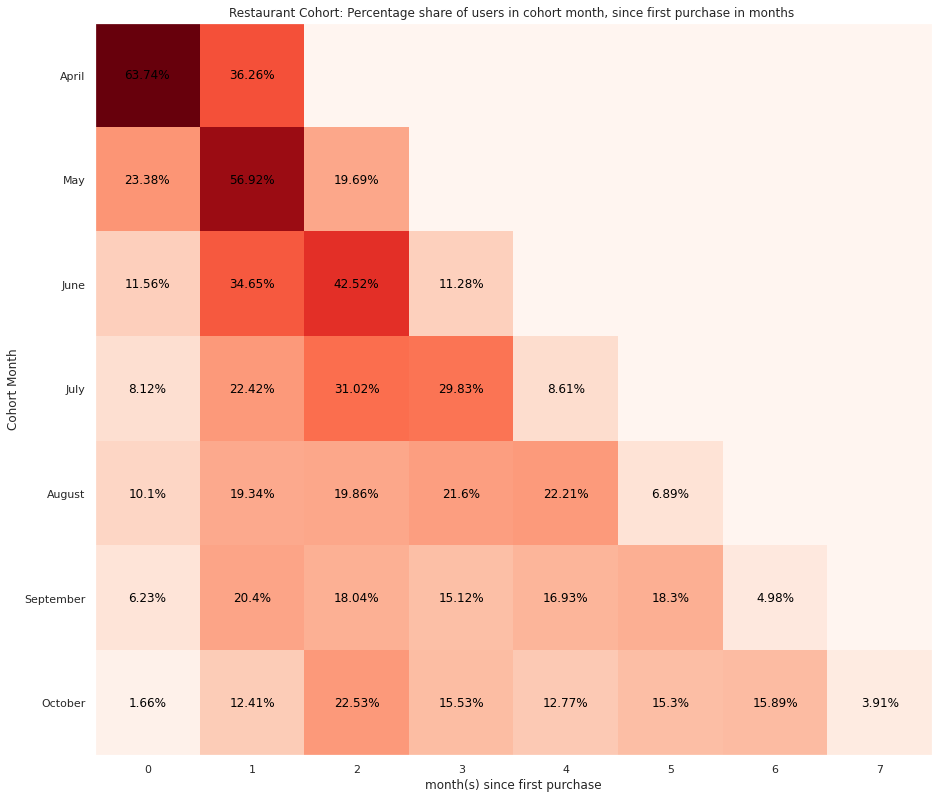

In [165]:
cohort_heatmap(cohort_restaurant_month)

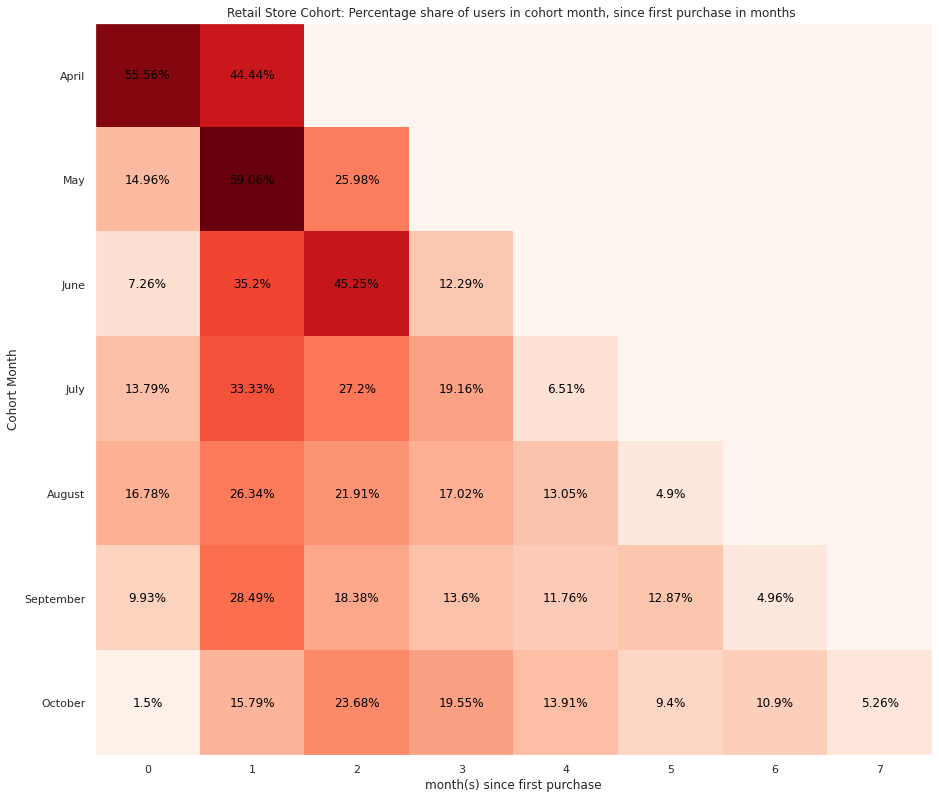

In [166]:
cohort_heatmap(cohort_retail_month)